In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from pydub import AudioSegment
from pydub.playback import play

In [26]:
audio = AudioSegment.from_file("../데이터수집/바로 이 목소리/15master.mp3")

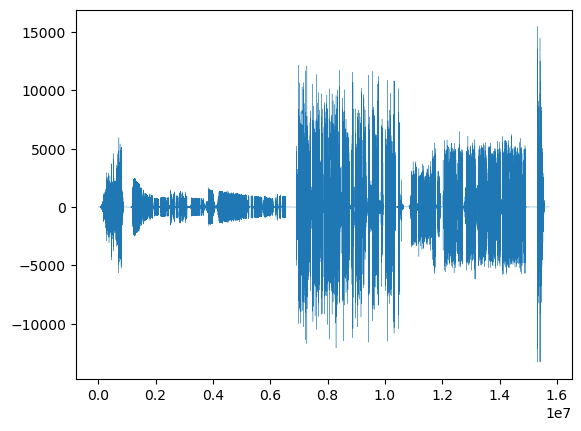

In [28]:
# play(audio)
x = audio.get_array_of_samples()
plt.plot(x, linewidth = 0.25)

In [20]:
# sampling rate, 44100 = 44.1khz, 단위시간당 샘플 수, 1초당 44100개의 샘플
print(audio.frame_rate)

# bit-depth, 2, 2-byte = 16-bit(2^16) digital sample, resolution, 범위는 (-2**15, 2**15-1)
print(audio.sample_width) # !!! 소리 크기를 결정?

# channel, 2 = 좌우, 6 = 서라운드
print(audio.channels)

# audio 데이터의 개수 = sample rate x channel x playtime

44100
2
2


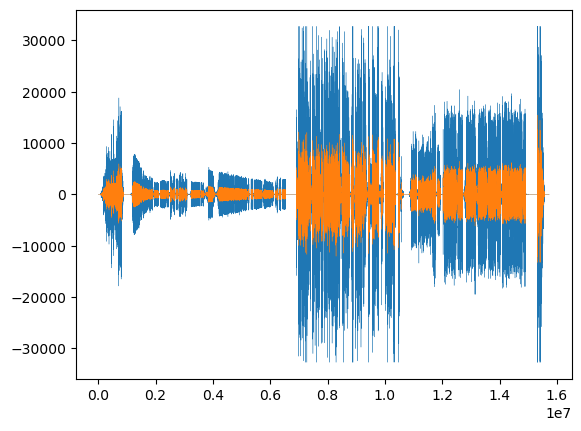

In [34]:
#%% boost volume by 10dB
# play(audio)
boost_audio = audio + 10
y = boost_audio.get_array_of_samples()
plt.plot(y, linewidth=.25)
plt.plot(x, linewidth=.25)


In [42]:
modi_sound = np.int16(np.array(x) * 3.16)
np.fft.fft(modi_sound, n=100)
np.linspace(0, 4 * np.pi, num = 44100 * 2 * 2)

array([0.00000000e+00, 7.12383325e-05, 1.42476665e-04, ...,
       1.25662281e+01, 1.25662994e+01, 1.25663706e+01])

Text(0.5, 0, 'Freq')

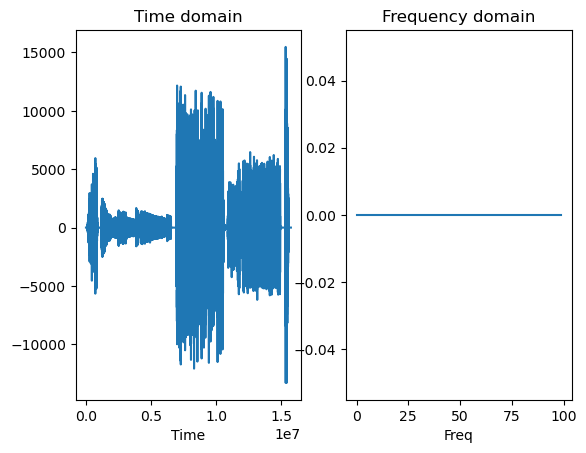

In [35]:
#%% 이산푸리에변환 DFT
dct = np.fft.fft(x, n=100)
# !!! np.fft.fft(x, n), n개의 벡터가 데이터 x를 설명함.
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(x)
axes[1].plot(np.abs(dct))   # !!! - 복소수 a, => |a|: 주파수 대역별 설명력
axes[0].set_title("Time domain")
axes[1].set_title("Frequency domain")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Freq")

In [ ]:
# comparison of different type of music
rock = AudioSegment.from_file("Enough.mp3",
                              format="mp3")
play(rock)
rock_x = rock.get_array_of_samples()
rock_dct = np.fft.fft(rock_x, 44100*2*10)
pop = AudioSegment.from_file("As You Fade Away.mp3",
                              format="mp3")
play(pop)
pop_x = pop.get_array_of_samples()
pop_dct = np.fft.fft(pop_x, 44100*2*10)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(np.abs(rock_dct))
axes[1].plot(np.abs(pop_dct))
axes[0].set_title("ROCK")
axes[1].set_title("POP")
axes[0].set_xlabel("Freq")
axes[1].set_xlabel("Freq")
axes[0].set_ylim([0, 1e+7])
axes[1].set_ylim([0, 1e+7])

#%% 실습 1
def extract_feature_audio(audio, n):
    x = audio.get_array_of_samples()
    dct = np.fft.fft(x, n=n)
    feature = np.abs(dct)
    return(feature)

path = r"C:\Users\uowol\Desktop\대학\3학년 1학기\데이터시각화\기말\chapter 6\gun_train"
audio_feature_list = list()
labels_list = list()

file_list = os.listdir(path)
for file in file_list:
    try:
        audio = AudioSegment.from_file(
            path+"/"+file, format="wav")
    except:
        continue
    feature = extract_feature_audio(audio
                                    , n=1000)
    audio_feature_list.append(feature)
    labels_list.append(file)

import re
import pandas as pd

r = re.compile("[_|-]")
labels = [r.split(s)[0] for s in labels_list]

mat = np.vstack(audio_feature_list) # !!! 배열을 위에서 아래로 붙임
len(mat[0])
dat = pd.DataFrame(mat) # !!! vstack -> columns
dat.columns = ["V"+str(i)\
               for i in range(1, dat.shape[1] + 1)]
dat["labels"] = labels

train_dat = dat.loc[
    dat.labels.isin(["knife", "m4a1", "usp"])].copy()
train_dat["y"] = np.where(
    train_dat.labels == "knife", 1, 0)  # !!! condition, true, false
train_dat = train_dat.drop(columns = "labels")

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = "liblinear",
                           random_state = 0)
X = train_dat.drop(columns="y").values
y = train_dat.y.values

fit_res = model.fit(X, y)
pred_y = fit_res.predict(X) # !!! 분류
fit_res.predict_proba(X)    # !!! 확률

# cross table fore ture y vs predicted y
pd.crosstab(y, pred_y)

test_audio1 = AudioSegment.from_file(
    r".\gun_test\test1.wav", format='wav')
test_audio2 = AudioSegment.from_file(
    r".\gun_test\test2.wav", format='wav')

test1 = extract_feature_audio(test_audio1, 1000)
test2 = extract_feature_audio(test_audio2, 1000)

pred1 = fit_res.predict(
    test1.reshape(1, test1.shape[0]))
pred2 = fit_res.predict(
    test2.reshape(1, test2.shape[0]))
